# Model Comparison: RF vs SVM

Cross-model evaluation built from the final Random Forest (Isaac) and SVM (Michael) notebooks.

## Goals
- Load the shared dataset and recreate both pipelines (RF, SVM-RBF)
- Produce a single metrics table (ROC-AUC, accuracy, precision, recall, F1)
- Run significance tests on paired predictions
- Visualise ROC curves, metric comparisons, and feature importance
- Summarise trade-offs: accuracy vs interpretability, complexity vs performance, training vs prediction speed

## 2. Setup and Data Preparation

### 2.1 Import libraries- Machine learning (sklearn classifiers and evaluation tools)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance
from scipy.stats import chi2
rng = np.random.default_rng(42)
sns.set_theme(style="whitegrid")

### 2.2 Load Data

**What we're doing:** Loading the same cleaned accident dataset used in the individual notebooks and applying the same transformations

In [48]:
# Load data and derive target
df = pd.read_csv('../../data/final/data_post_eda.csv')
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

def map_severity(sev):
    non_fatal = ['not injured', 'slight', 'grievious', 'serious']
    fatal = ['fatal']
    if sev in non_fatal:
        return 0
    if sev in fatal:
        return 1
    return np.nan

df['is_fatal'] = df['accident_severity'].apply(map_severity)
df = df.dropna(subset=['is_fatal']).copy()
df['is_fatal'] = df['is_fatal'].astype(int)
print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(df['is_fatal'].value_counts())

Dataset: 211 rows, 59 columns
is_fatal
0    183
1     28
Name: count, dtype: int64


### 2.3 Feature Selection

Using the same set of features for all model, based on the EDA:

**Our feature set includes:**
- **3 Categorical features:** region, street_type, accident_time_category (text categories that get converted to numbers)
- **17 Numerical features:** driver demographics, vehicle counts, weather, date info

**Important:** All models use the exact same features for fair comparison.

In [ ]:
# Feature set (aligned with RF notebook to keep parity across models)
cat_cols = ['region', 'street_type', 'accident_time_category']
num_cols = [
    'num_drivers_under_18',
    'num_drivers_18_to_24',
    'num_drivers_25_to_49',
    'num_drivers_50_to_64',
    'num_drivers_65_plus',
    'num_drivers_male',
    'num_drivers_female',
    'num_vehicle_unknown',
    'num_vehicle_pedestrian',
    'num_vehicle_bicycle',
    'num_vehicle_motorbike',
    'num_vehicle_car',
    'num_vehicle_van',
    'is_weekend',
    'is_school_holiday_mt',
    'temperature_mean',
    'is_raining'
]
X = df[cat_cols + num_cols].copy()
y = df['is_fatal']
print(f"Features: {X.shape[1]} columns; Target positive rate: {y.mean():.3f}")

Features: 20 columns; Target positive rate: 0.133


## 3. Pipeline Architecture

**Key Design Principle:** Each model is wrapped in a scikit-learn Pipeline (preprocessing + classifier) to ensure clean reproducability and fair comparison.

**Pipeline Structure:**
- **RandomForest Pipeline:** Preprocessing (no scaling) → RF Classifier
- **SVM Pipeline:** Preprocessing (with StandardScaler) → SVM Classifier

All models use identical:
- Feature set (19 columns: 3 categorical + 16 numerical)
- CV strategy (StratifiedKFold, n_splits=5, random_state=42)
- Train/test split (80/20, stratified, random_state=42)
- Evaluation metrics (ROC-AUC, accuracy, precision, recall, F1)

### 3.1 Preprocessing Pipelines

 **SVM:** Needs scaling because it's sensitive to feature magnitudes

 **Random Forest:** Doesn't need scaling (tree-based algorithm)


In [ ]:
# Preprocessing blocks
cat_ohe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_med = Pipeline([
    ('imp', SimpleImputer(strategy='median'))
])

num_scaled = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

preprocess_rf = ColumnTransformer([
    ('cat', cat_ohe, cat_cols),
    ('num', num_med, num_cols)
])

preprocess_svm = ColumnTransformer([
    ('cat', cat_ohe, cat_cols),
    ('num', num_scaled, num_cols)
])

### 3.2 Complete Model Pipelines

Each pipeline combines preprocessing + classifier as a single estimator.

In [20]:
# Models from the two notebooks (hyperparameters kept the same when available)
rf_model = Pipeline([
    ('prep', preprocess_rf),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        class_weight={0: 1, 1: 3},
        n_jobs=-1,
        max_depth=20,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=0.5,
        max_samples=1.0,
        random_state=42
    ))
])

svm_model = Pipeline([
    ('prep', preprocess_svm),
    ('svm', SVC(C=5, kernel='rbf', probability=True, random_state=42))
])

models = OrderedDict([
    ('RandomForest', rf_model),
    ('SVM_RBF', svm_model)
])

### 3.3 Cross-Validation Setup

**What is cross-validation?** Instead of a single train/test split, we split the data 5 different ways and test each model 5 times. This gives more reliable performance estimates and is more suited for a small dataset.

All models see the exact same data splits, making comparison fair.

In [31]:
# Cross-validation metrics table
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

records = []
for name, model in models.items():
    res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    records.append({
        'model': name,
        'roc_auc_mean': res['test_roc_auc'].mean(), 'roc_auc_std': res['test_roc_auc'].std(),
        'accuracy_mean': res['test_accuracy'].mean(), 'accuracy_std': res['test_accuracy'].std(),
        'precision_mean': res['test_precision'].mean(), 'precision_std': res['test_precision'].std(),
        'recall_mean': res['test_recall'].mean(), 'recall_std': res['test_recall'].std(),
        'f1_mean': res['test_f1'].mean(), 'f1_std': res['test_f1'].std(),
    })

metrics_table = pd.DataFrame.from_records(records).set_index('model')
metrics_table

,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std
model,,,,,,,,,,
RandomForest,0.875601,0.088070,0.895903,0.017719,0.800000,0.400000,0.213333,0.122202,0.333333,0.182574
SVM_RBF,0.867497,0.072254,0.881617,0.033225,0.633333,0.250555,0.360000,0.130639,0.446667,0.144085


## 4. Model Evaluation

### 4.1 Hold-Out Test Set

**Split:** 80% training, 20% validation (stratified to maintain class balance)

**Purpose:** Create a single validation set that both models are tested on. This allows us to:

1. Directly compare predictions on the same samples3. Generate confusion matrices and ROC curves
2. Run statistical significance tests

In [ ]:
# Hold-out set for paired significance tests and plots
# Split data: 80% train, 20% validation
# stratify=y maintains same fatal/non-fatal ratio in both sets
# random_state=42 ensures reproducibility and same split for both models
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Store predictions for both models on the SAME validation set
val_preds = {}   # Hard predictions (0 or 1) using default 0.5 threshold
val_probas = {}  # Probability scores (0.0 to 1.0) for positive class (fatal)

# Train each model and generate predictions on validation set
for name, model in models.items():
    # Fit the entire pipeline (preprocessing + classifier) on training data
    fitted = model.fit(X_train, y_train)
    
    # Get hard predictions (0=non-fatal, 1=fatal) using 0.5 threshold
    val_preds[name] = fitted.predict(X_val)
    
    # Get probability of fatal class (column 1) for ROC curves and custom thresholds
    val_probas[name] = fitted.predict_proba(X_val)[:, 1]

# Print average positive prediction rate for each model
print({k: v.mean() for k, v in val_preds.items()})

{'RandomForest': np.float64(0.023255813953488372), 'SVM_RBF': np.float64(0.06976744186046512)}


### 4.2 Confusion Matrices (Default Threshold = 0.5)

**What is a confusion matrix?** A table showing how many predictions were correct vs incorrect:
- **TP (True Positive):** Correctly predicted fatal
- **TN (True Negative):** Correctly predicted non-fatal
- **FP (False Positive):** Predicted fatal but was actually non-fatal (false alarm)
- **FN (False Negative):** Predicted non-fatal but was actually fatal (missed detection)

**Threshold 0.5 means:** If the model thinks there's >50% chance of fatality, predict "fatal".

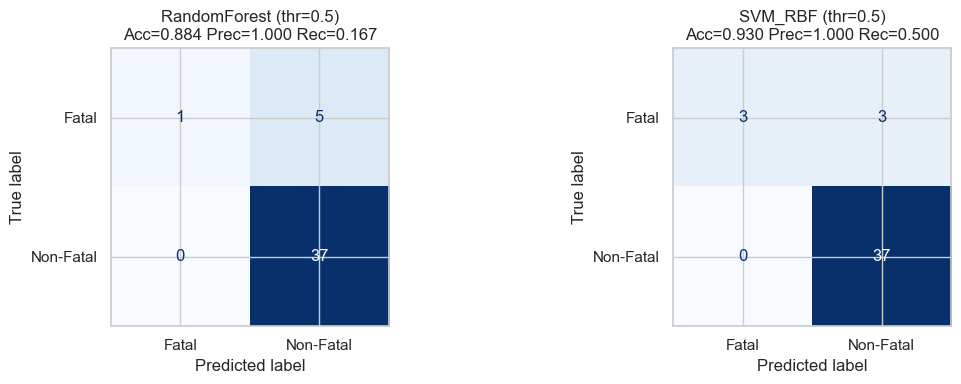


Default 0.5 threshold metrics:
RandomForest: TP=1, FP=0, FN=5, TN=37
SVM_RBF: TP=3, FP=0, FN=3, TN=37


In [41]:
# Confusion matrices on the hold-out split for both models (default 0.5 threshold)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, preds) in zip(axes, val_preds.items()):
    cm = confusion_matrix(y_val, preds, labels=[1, 0])  # [positive, negative]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Non-Fatal'])
    disp.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')
    
    # Calculate metrics
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    ax.set_title(f"{name} (thr=0.5)\nAcc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f}")
plt.tight_layout()
plt.show()

print("\nDefault 0.5 threshold metrics:")
for name in val_preds.keys():
    cm = confusion_matrix(y_val, val_preds[name], labels=[1, 0])
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    print(f"{name}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

### 4.3 Confusion Matrices (Custom Threshold = 0.3)

**Why change the threshold?** Lower threshold (0.3 instead of 0.5) means:
- Model predicts "fatal" more often
- Higher recall (catches more actual fatal cases)
- Lower precision (more false alarms)

**Use case:** In safety applications, missing a fatal accident (FN) is worse than a false alarm (FP), so we lower the threshold to catch more fatalities.

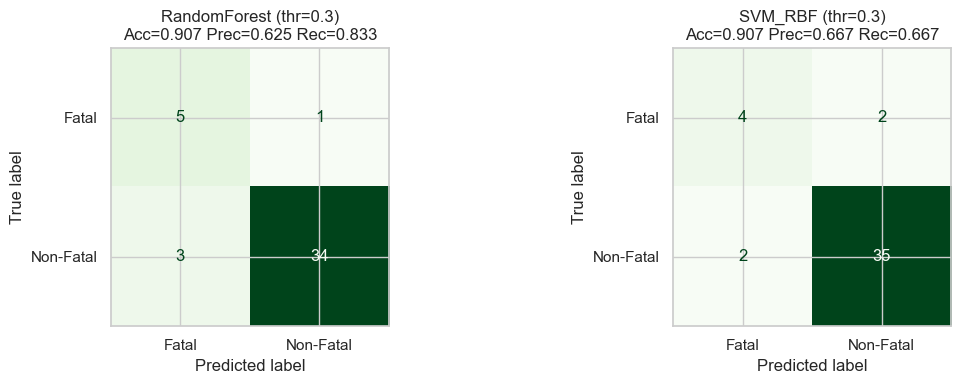


Custom 0.3 threshold metrics (matches RF notebook approach):
RandomForest: TP=5, FP=3, FN=1, TN=34
SVM_RBF: TP=4, FP=2, FN=2, TN=35


In [42]:
# Confusion matrices with custom 0.3 threshold (matching RF notebook approach)
CUSTOM_THRESHOLD = 0.3
val_preds_custom = {}
for name, probs in val_probas.items():
    val_preds_custom[name] = (probs >= CUSTOM_THRESHOLD).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, (name, preds) in zip(axes, val_preds_custom.items()):
    cm = confusion_matrix(y_val, preds, labels=[1, 0])  # [positive, negative]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fatal', 'Non-Fatal'])
    disp.plot(ax=ax, cmap='Greens', colorbar=False, values_format='d')
    
    # Calculate metrics
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    ax.set_title(f"{name} (thr=0.3)\nAcc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f}")
plt.tight_layout()
plt.show()

print(f"\nCustom {CUSTOM_THRESHOLD} threshold metrics (matches RF notebook approach):")
for name in val_preds_custom.keys():
    cm = confusion_matrix(y_val, val_preds_custom[name], labels=[1, 0])
    tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
    print(f"{name}: TP={tp}, FP={fp}, FN={fn}, TN={tn}")

### 4.4 Detailed Metrics Comparison

**Key metrics explained:**
- **Accuracy:** Overall correctness (TP + TN) / Total
- **Precision:** Of all "fatal" predictions, how many were correct? TP / (TP + FP)
- **Recall (Sensitivity):** Of all actual fatals, how many did we catch? TP / (TP + FN)
- **Specificity:** Of all actual non-fatals, how many did we correctly identify? TN / (TN + FP)
- **F1 Score:** Balance between precision and recall (harmonic mean)

**Trade-off:** High recall = catch more fatalities but more false alarms. High precision = fewer false alarms but miss some fatalities.

In [43]:
# Detailed metrics breakdown for both models at both thresholds
print("="*70)
print("DETAILED METRICS COMPARISON")
print("="*70)

for threshold_name, preds_dict in [("Default (0.5)", val_preds), ("Custom (0.3)", val_preds_custom)]:
    print(f"\n{'='*70}")
    print(f"THRESHOLD: {threshold_name}")
    print(f"{'='*70}")
    
    for name, preds in preds_dict.items():
        cm = confusion_matrix(y_val, preds, labels=[1, 0])
        tn, fp, fn, tp = cm[1, 1], cm[1, 0], cm[0, 1], cm[0, 0]
        
        classification_accuracy = (tp + tn) / float(tp + tn + fp + fn)
        classification_error = (fp + fn) / float(tp + tn + fp + fn)
        precision = tp / float(tp + fp) if (tp + fp) > 0 else 0
        recall = tp / float(tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n{name}:")
        print(f"  TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"  Classification accuracy : {classification_accuracy:.4f}")
        print(f"  Classification error   : {classification_error:.4f}")
        print(f"  Precision             : {precision:.4f}")
        print(f"  Recall (Sensitivity)  : {recall:.4f}")
        print(f"  Specificity           : {specificity:.4f}")
        print(f"  F1 Score              : {f1:.4f}")

DETAILED METRICS COMPARISON

THRESHOLD: Default (0.5)

RandomForest:
  TP=1, FP=0, FN=5, TN=37
  Classification accuracy : 0.8837
  Classification error   : 0.1163
  Precision             : 1.0000
  Recall (Sensitivity)  : 0.1667
  Specificity           : 1.0000
  F1 Score              : 0.2857

SVM_RBF:
  TP=3, FP=0, FN=3, TN=37
  Classification accuracy : 0.9302
  Classification error   : 0.0698
  Precision             : 1.0000
  Recall (Sensitivity)  : 0.5000
  Specificity           : 1.0000
  F1 Score              : 0.6667

THRESHOLD: Custom (0.3)

RandomForest:
  TP=5, FP=3, FN=1, TN=34
  Classification accuracy : 0.9070
  Classification error   : 0.0930
  Precision             : 0.6250
  Recall (Sensitivity)  : 0.8333
  Specificity           : 0.9189
  F1 Score              : 0.7143

SVM_RBF:
  TP=4, FP=2, FN=2, TN=35
  Classification accuracy : 0.9070
  Classification error   : 0.0930
  Precision             : 0.6667
  Recall (Sensitivity)  : 0.6667
  Specificity           : 0.9

### 4.5 ROC Curves

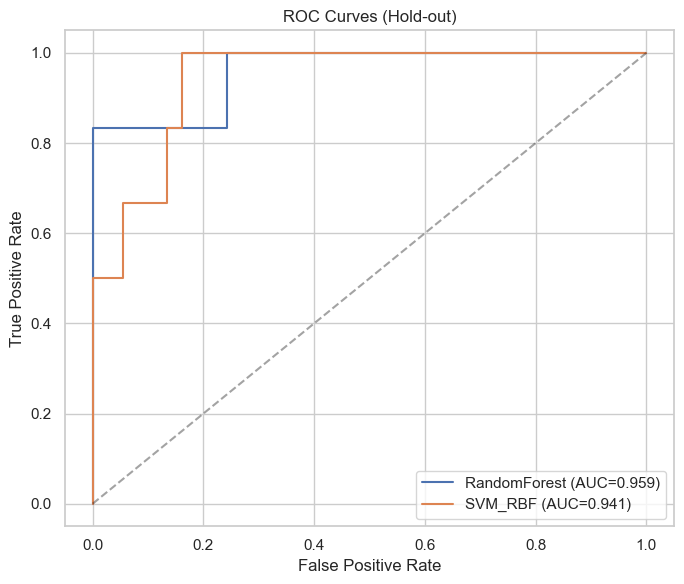

In [44]:
# ROC curves on the shared hold-out split
fig, ax = plt.subplots(figsize=(7, 6))
for name, probs in val_probas.items():
    fpr, tpr, _ = roc_curve(y_val, probs)
    auc = roc_auc_score(y_val, probs)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves (Hold-out)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

### 4.6 Visual Metrics Comparison

**What this shows:** Side-by-side comparison of both models across all 5 metrics from cross-validation.

**Interpretation:** Taller bars = better performance for that metric.

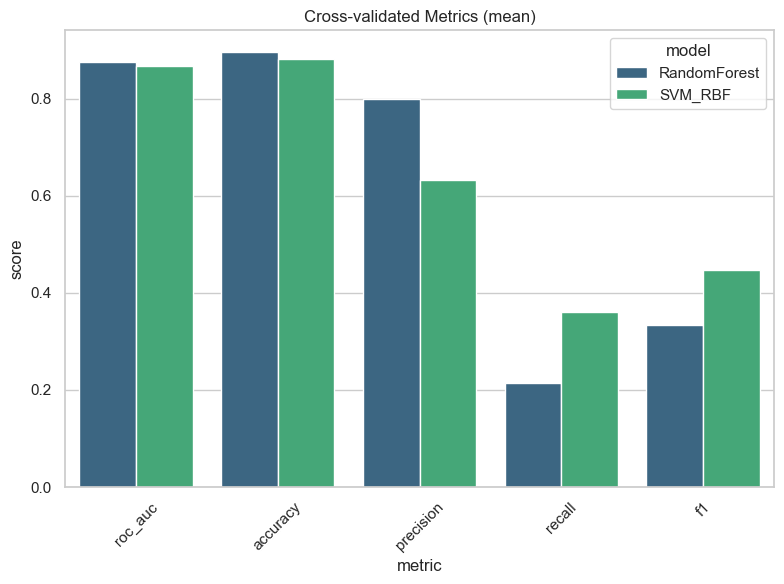

In [47]:
# Metric comparison bar plot (means from cross-validation)
plot_df = metrics_table[[c for c in metrics_table.columns if c.endswith('mean')]].rename(
    columns=lambda c: c.replace('_mean', '')
).reset_index().melt(id_vars='model', var_name='metric', value_name='score')
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='metric', y='score', hue='model', palette='viridis')
plt.title('Cross-validated Metrics (mean)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()